In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

import tensorflow as tf

In [2]:
fname_train = '../data/train.pkl'
fname_test = '../data/test.pkl'

with open(fname_train, 'rb') as inp:
    word2id = pickle.load(inp)
    id2word = pickle.load(inp)
    relation2id = pickle.load(inp)
    entity2id = pickle.load(inp)
    train = pickle.load(inp)
    labels = pickle.load(inp)
    position1 = pickle.load(inp)
    position2 = pickle.load(inp)
    E = pickle.load(inp)
inp.close()

with open(fname_test, 'rb') as inp:
    test = pickle.load(inp)
    labels_t = pickle.load(inp)
    position1_t = pickle.load(inp)
    position2_t = pickle.load(inp)
    E_t = pickle.load(inp)
inp.close()

print("train len", len(train))
print("test len", len(test))
print("word2id len", len(word2id))

train len 2064
test len 688
word2id len 561


In [3]:
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_SIZE = len(word2id) + 1
EMBEDDING_DIM = 200

POS_SIZE = 38*2+1 
POS_DIM = 25
ENTITY_DIM = 25 
HIDDEN_DIM = 100 


TAG_SIZE = len(relation2id)
ENTITY_SIZE = len(entity2id)


In [4]:
embedding_matrix = np.random.random((len(word2id) + 1, EMBEDDING_DIM))
for word, i in word2id.items():
    embedding_vector = word2id[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

word_embeds = Embedding(len(word2id) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable=True)

#pos1_embeds = Embedding(POS_SIZE,POS_DIM,input_length = MAX_SEQUENCE_LENGTH)
#pos2_embeds = Embedding(POS_SIZE,POS_DIM,input_length = MAX_SEQUENCE_LENGTH)
#e_embeds = Embedding(ENTITY_SIZE,ENTITY_DIM,input_length = MAX_SEQUENCE_LENGTH)

In [5]:
from attention import Attention

In [6]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
pos1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
pos2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
e_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

word_embedding = word_embeds(sequence_input)
print("word_embedding:",word_embedding.shape)
word_embedding = Bidirectional(LSTM(128, return_sequences=True))(word_embedding)
print("word_embedding:",word_embedding.shape)
word_embedding = Attention(MAX_SEQUENCE_LENGTH)(word_embedding)
print("word_embedding:",word_embedding.shape)

#pos1_embedding =  pos1_embeds(pos1_input)
#pos2_embedding =  pos2_embeds(pos2_input)
#e_embedding = e_embeds(e_input)
pos1 = Dense(64,input_shape=(input,))(pos1_input)
pos2 = Dense(64,input_shape=(input,))(pos2_input)
e = Dense(128,input_shape=(input,))(e_input)

print("pos1:",pos1)
print("pos2:",pos2)
print("e:",e)

pos = tf.concat([pos1,pos2], 1)
print("pos:",pos)
pos_e = tf.concat([pos,e], 1)
print("pos_e:",pos_e)

#pos_e_lstm = Bidirectional(LSTM(128))(pos_e)
#print("pos_e_lstm:",pos_e_lstm)
feature = tf.concat([pos_e,word_embedding], 1)
print("feature:",feature)

feature = Dense(64)(feature)
print("feature:",feature)

preds = Dense(len(relation2id), activation='softmax')(feature)

model = Model([sequence_input,pos1_input,pos2_input, e_input],preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

word_embedding: (None, 150, 200)
word_embedding: (None, 150, 256)
word_embedding: (None, 256)
pos1: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")
pos2: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='dense_1/BiasAdd:0', description="created by layer 'dense_1'")
e: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='dense_2/BiasAdd:0', description="created by layer 'dense_2'")
pos: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.concat/concat:0', description="created by layer 'tf.concat'")
pos_e: KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='tf.concat_1/concat:0', description="created by layer 'tf.concat_1'")
feature: KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.float32, name=None), name='tf.concat_2/concat:0', descr

In [7]:
#Train = tf.concat([train,position1,position2,E],1)

In [8]:
#Train.shape

In [9]:
#Test = tf.concat([test,position1_t,position2_t,E_t],1)

In [10]:
#Test.shape

In [11]:
labels = pd.DataFrame(labels)
labels = pd.get_dummies(labels[0])
labels = np.asarray(labels)

In [12]:
labels_t = pd.DataFrame(labels_t)
labels_t = pd.get_dummies(labels_t[0])
labels_t = np.asarray(labels_t)

In [13]:
labels.shape

(2064, 6)

In [14]:
labels_t.shape

(688, 6)

In [15]:
cp = ModelCheckpoint('model_bilstm.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history = model.fit([train,position1,position2,E], labels,epochs= 50, batch_size = 64,callbacks=[cp])

Epoch 1/50
33/33 [==============================] - 28s 680ms/step - loss: 20.5680 - acc: 0.3880
Epoch 2/50
33/33 [==============================] - 23s 682ms/step - loss: 3.9454 - acc: 0.5189
Epoch 3/50
33/33 [==============================] - 23s 679ms/step - loss: 1.8271 - acc: 0.5801
Epoch 4/50
33/33 [==============================] - 23s 705ms/step - loss: 1.7112 - acc: 0.5774
Epoch 5/50
33/33 [==============================] - 23s 692ms/step - loss: 1.4150 - acc: 0.6240
Epoch 6/50
33/33 [==============================] - 23s 704ms/step - loss: 1.4781 - acc: 0.6178
Epoch 7/50
33/33 [==============================] - 23s 685ms/step - loss: 1.1259 - acc: 0.6760
Epoch 8/50
33/33 [==============================] - 22s 677ms/step - loss: 0.9314 - acc: 0.6975
Epoch 9/50
33/33 [==============================] - 24s 734ms/step - loss: 1.0978 - acc: 0.7087
Epoch 10/50
33/33 [==============================] - 24s 730ms/step - loss: 1.2125 - acc: 0.6714
Epoch 11/50
33/33 [===================

33/33 [==============================] - 27s 827ms/step - loss: 0.4428 - acc: 0.8285
Epoch 48/50
33/33 [==============================] - 24s 737ms/step - loss: 0.4008 - acc: 0.8380
Epoch 49/50
33/33 [==============================] - 24s 734ms/step - loss: 0.3907 - acc: 0.8488
Epoch 50/50
33/33 [==============================] - 23s 707ms/step - loss: 0.3667 - acc: 0.8439


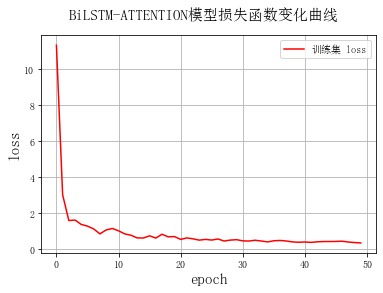

In [16]:
plt.rcParams['font.sans-serif']=['simsun'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

fig, ax = plt.subplots()#创建一个figure 
ax.plot(history.history['loss'], '-r', label='训练集 loss')

####打开网格
ax.grid(True)

####定义x, y轴的名称
ax.set_xlabel('epoch',fontsize=15)
ax.set_ylabel('loss',fontsize=15)

####定义标题
fig.suptitle('BiLSTM-ATTENTION模型损失函数变化曲线',fontsize=15)

####展示图例 legend loc=是用来定义图例的位置的，还有很多选择，大家可以自己尝试
ax.legend(loc = 'upper right')

plt.savefig("BiLSTM-ATTENTION模型损失函数变化曲线.png")

In [17]:
pred_test = model.predict([test,position1_t,position2_t,E_t])

In [18]:
len(history.history['loss'])

50

In [19]:
history.history['loss']

[11.346717834472656,
 3.040113925933838,
 1.6086716651916504,
 1.6339318752288818,
 1.3905282020568848,
 1.2992615699768066,
 1.1412734985351562,
 0.8667906522750854,
 1.0843898057937622,
 1.1677623987197876,
 1.0375237464904785,
 0.8658561706542969,
 0.7910088896751404,
 0.6439255475997925,
 0.6379189491271973,
 0.7595102787017822,
 0.6347583532333374,
 0.8475263714790344,
 0.7023013830184937,
 0.7185420989990234,
 0.559404194355011,
 0.642833411693573,
 0.5913205742835999,
 0.5197020769119263,
 0.5616215467453003,
 0.5240775346755981,
 0.5838339924812317,
 0.4706699252128601,
 0.5219316482543945,
 0.5454595685005188,
 0.47962963581085205,
 0.46874138712882996,
 0.5135476589202881,
 0.4689042568206787,
 0.4222675859928131,
 0.48430511355400085,
 0.5017298460006714,
 0.47211024165153503,
 0.421494722366333,
 0.40249937772750854,
 0.4154009521007538,
 0.3959157168865204,
 0.4270186722278595,
 0.4418235719203949,
 0.4432675242424011,
 0.4468246102333069,
 0.46086159348487854,
 0.41563919

In [20]:
labels_t

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [21]:
res = model.predict([test,position1_t,position2_t,E_t])

In [22]:
res

array([[9.95501409e-07, 1.49141485e-03, 1.69380009e-01, 8.29127491e-01,
        3.39981376e-08, 1.01508505e-07],
       [2.86629017e-07, 1.68562210e-07, 5.20551344e-04, 3.72925820e-06,
        9.49310422e-01, 5.01648113e-02],
       [7.91935742e-01, 1.28055282e-04, 6.62622199e-07, 6.79742596e-10,
        1.65711401e-06, 2.07933843e-01],
       ...,
       [3.14280540e-01, 1.02082446e-07, 1.72127293e-05, 9.95970098e-08,
        3.20062338e-10, 6.85702026e-01],
       [4.97032193e-09, 3.24955327e-04, 8.84964883e-01, 1.14708833e-01,
        1.02100381e-08, 1.40856491e-06],
       [1.55347415e-08, 3.85225540e-08, 1.94977317e-03, 6.77727041e-10,
        9.70312589e-13, 9.98050213e-01]], dtype=float32)

In [23]:
result = []
for item in res:
    ls = list(item)
    idx = ls.index(max(ls))
    add_ls = [0]*6
    add_ls[idx] = 1
    result.append(add_ls)

In [24]:
result

[[0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0,

In [25]:
from sklearn.metrics import classification_report
print(classification_report(labels_t,result,digits = 4))

              precision    recall  f1-score   support

           0     0.8502    0.8470    0.8486       268
           1     0.7586    0.6471    0.6984        68
           2     0.4762    0.6061    0.5333        33
           3     0.6000    0.6000    0.6000        50
           4     0.8919    0.6600    0.7586        50
           5     0.7650    0.8174    0.7903       219

   micro avg     0.7747    0.7747    0.7747       688
   macro avg     0.7236    0.6962    0.7049       688
weighted avg     0.7809    0.7747    0.7755       688
 samples avg     0.7747    0.7747    0.7747       688



In [26]:
list(labels_t[0]).index(1)

3

In [27]:
labels_t_list = []
for i in labels_t:
    res = list(i).index(1)
    labels_t_list.append(res)
    

In [28]:
result_list = []
for i in result:
    res = list(i).index(1)
    result_list.append(res)
    

In [29]:
print(classification_report(labels_t_list,result_list,digits = 4))

              precision    recall  f1-score   support

           0     0.8502    0.8470    0.8486       268
           1     0.7586    0.6471    0.6984        68
           2     0.4762    0.6061    0.5333        33
           3     0.6000    0.6000    0.6000        50
           4     0.8919    0.6600    0.7586        50
           5     0.7650    0.8174    0.7903       219

    accuracy                         0.7747       688
   macro avg     0.7236    0.6962    0.7049       688
weighted avg     0.7809    0.7747    0.7755       688

